# Semantic Segmentation

In this tutorial we will fine tune a U-NET model for semantic segmentation on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [2]:
import cv2
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torchmetrics import JaccardIndex

## Data Preparation

In [3]:
# get train and validation datasets
images_directory = "images"
masks_directory = os.path.join("annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
# filter out images that can not be loaded properly
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:2000]
val_images_filenames = correct_images_filenames[2000:2500]

print(len(train_images_filenames), len(val_images_filenames))

2000 500


In [4]:
# the dataset has 3 labels (1 - pet, 2 - background and 3 - border), so we convert it to a binary problem with (0 - background and 1 - pet/border)
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [5]:
# before proceeding, let us visualize some examples
def display_image_grid(images_filenames, images_directory, masks_directory):
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=2, figsize=(10, 24))
    
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap='gray')

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

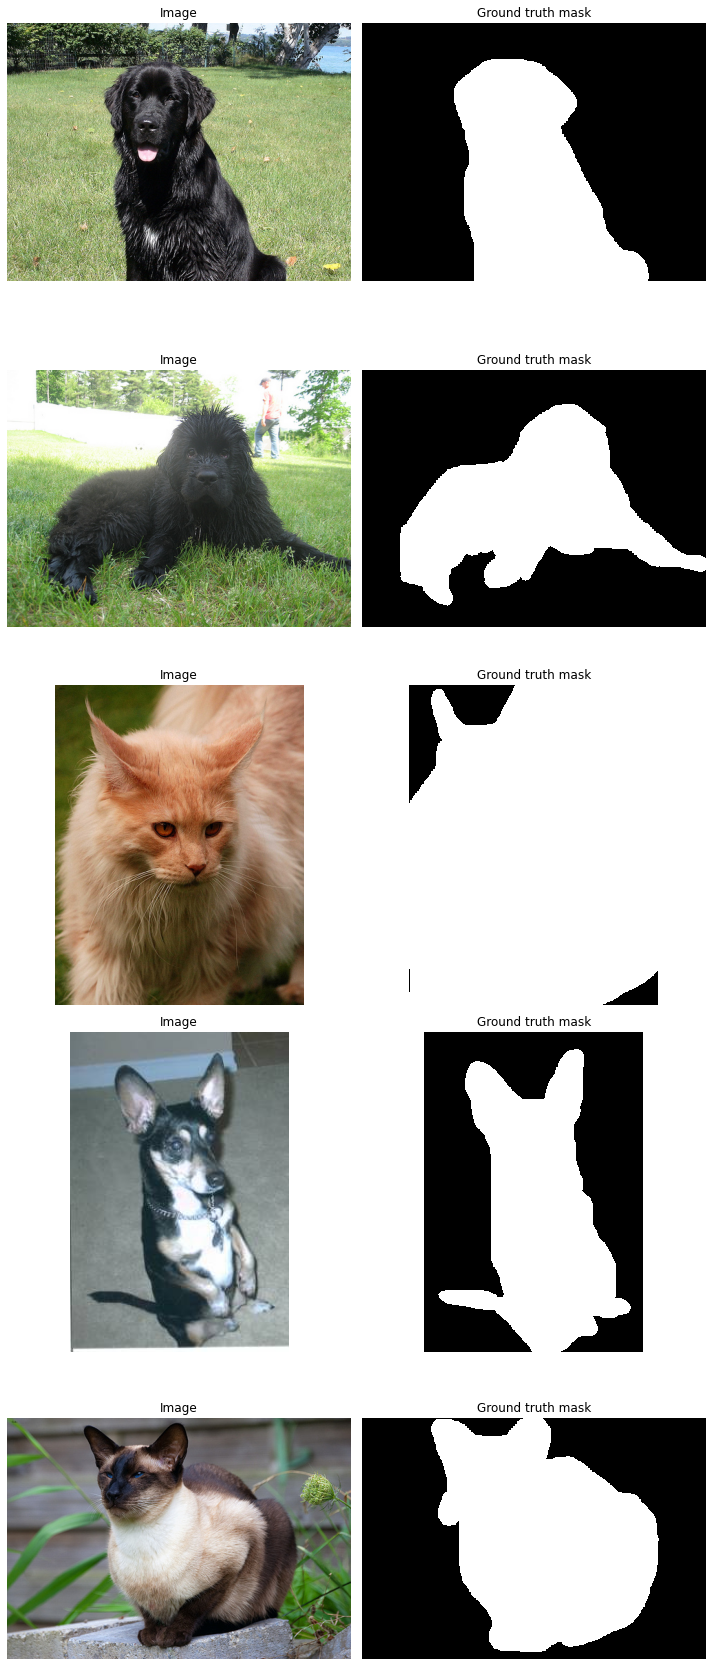

In [6]:
display_image_grid(train_images_filenames[:5], images_directory, masks_directory)

In [7]:
# let's define our dataset
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255

        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)

        # when applying data augmentation we need to make sure both input image and target mask are augmented using exactly the same augmentation
        # this is straightforward using the albumentations library (https://github.com/albumentations-team/albumentations)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image.float(), mask.to(torch.int64)

In [14]:
# hyperparameters
nr_classes = 2
batch_size = 5
num_workers = 4
epochs = 10
learning_rate = 1e-3

# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
# define transforms and datasets
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_transform = A.Compose(
    [A.Resize(256, 256), A.CenterCrop(224, 224), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

## Model

In [10]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SegmentationNetwork(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(SegmentationNetwork, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits

Analyse the implemented SegmentationNetwork. 

What type of architecture is being implemented? 

What is the shape of the output and embedding tensors?

## Train the model

In [20]:
# create model
model = SegmentationNetwork(3, nr_classes)
print(model)

# put model in GPU
model.to(device)

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# define loss
loss_fn = nn.CrossEntropyLoss()

# define metric (e.g. Jaccard Index, Dice Coefficient, Pixel Accuracy)
metric = JaccardIndex(nr_classes)

SegmentationNetwork(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [17]:
# train the model (do not forget to save your best model during training)
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
	if is_train:
		assert optimizer is not None, "When training, please provide an optimizer."
	  
	num_batches = len(dataloader)

	if is_train:
		model.train() # put model in train mode
        
	else:
		model.eval()

	total_loss = 0.0
	preds = []
	labels = []

	with torch.set_grad_enabled(is_train):
		for batch, (X, y) in enumerate(tqdm(dataloader)):
			X, y = X.to(device), y.to(device)

			# Compute prediction error
			pred = model(X)
			loss = loss_fn(pred, y)

			if is_train:
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

			# Save training metrics
			total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

			probs = F.softmax(pred, dim=1)
			final_pred = torch.argmax(probs, dim=1)
			preds.extend(final_pred.cpu().numpy())
			labels.extend(y.cpu().numpy())

	return total_loss / num_batches, accuracy_score(labels, preds)

In [21]:
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")

for t in range(epochs):
	print(f"\nEpoch {t+1}")
	train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
	print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
	val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
	print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

	# save model when val loss improves
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
		torch.save(save_dict, 'best_model.pth')

	# save latest model
	save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
	torch.save(save_dict, 'latest_model.pth')

	# save training history for plotting purposes
	train_history["loss"].append(train_loss)
	train_history["accuracy"].append(train_acc)

	val_history["loss"].append(val_loss)
	val_history["accuracy"].append(val_acc)
	
print("Finished")

Start training...

Epoch 1


 78%|███████▊  | 314/400 [01:53<00:31,  2.76it/s]


KeyboardInterrupt: 

## Test the model

In [ ]:
# test the model on some images from the validation dataset
# compare the predicted with the ground-truth masks
# TODO

## Challenge
Add the Dice loss to the training of the network and compare the results.